# DATA_SCI 422 and EARTH 353 | Exercise 3

## Detecting, placing, and sizing a previously unknown tunnel

Imagine that there is an abandoned, very long, horizontal, underground tunnel beneath Chicago, but no one knows exactly where, how deep, and how large the tunnel is. Recently a geophysicist measured deficits in the acceleration of gravity over the area with the tunnel. One line of anomalous gravity values is provided to you and happens to be at right angles with the direction of the tunnel. The mass void of the tunnel causes of a local low in the measured values of the acceleration of gravity *g* at the surface. The anomalous gravity values given to you represent the vertical component of the anomalous gravity $\delta g_z (x)$. You are requested to invert these data for the depth to the center of the tunnel $z$ and the radius of the tunnel $r$. Approximating the tunnel by an infinitely long horizontal cylinder, we can write


$$ \delta g_z (x) = \frac{2\pi \cdot c \cdot \delta\rho \cdot r^2 \cdot z}{x^2+z^2}  $$

where $c = 6.67 \cdot 10^{-11} \: Nm^2/kg^2$ is the gravitational constant (more commonly, but not
here, referred to as $G$), $\delta\rho$ is the differential density between the tunnel and the surrounding rock (limestone), and $x$ is the horizontal distance (in m) along the survey line. The
$\delta g_z$ have been measured at every meter along the survey line, which is 100 m long, with an estimated error of $0.01 \: mgal$. One miligal (mgal) $= 10^{-5} \: m/s^2$ (about one $\mu g$). Knowing the rocks in the area, $\delta\rho$ has been estimated to be $-2700 \:  kg/m^3$. 
As you can tell from the equation, the gravity
data $\delta g_z$ depend linearly on $\delta\rho$ but non-linearly on $r$ and $z$. You will apply the linearization method explained in the course notes on Weakly Non-linear Problems and iteratively solve linearized versions of the inverse problem for small improvements $(\delta r, \delta z)$ to the estimated $(r, z)$, then finding the solution $(r, z)$ that best predicts the data in the least squares sense, via the following steps.


Q1: How many data points and model parameters do we have? How many rows and columns will $\mathbf G$ have? Is it likely that we will need data weighting (using the estimated data covariance matrix), model weighting (using the estimated prior model covariance matrix), or regularization to perform the inversion successfully? Why (not)?

In [220]:
# ANSWER 
#-------------------------------------------------------------------------
# We have two model parameters (r and z). We have 100 data points.
# G will have 100 rows and 2 columns. 
# It is likely that we will need data weighting to transform the non-linear 
# problem into a linear problem (and we will use Taylor Expansion). We want
# to find the radius and depth of a tunnel. We  wouldn't use model weighting 
# as there is no prior model covariance matrix, or regularization (our 
# problem is unlike that presented in Exercise 2. 
#-------------------------------------------------------------------------

# Find number of data elements in xdg.txt
xdg = open('xdg.txt','r').readlines()
print("Data points:", len(xdg))

Data points: 100


Q2: The inverse problem can be linearized using a first-order Taylor expansion:
$$ d_i = G_{i1}\cdot \Delta r + G_{i2}\cdot \Delta z $$
where
$$ G_{i1} = \frac{\partial(\delta g_z(x_i))}{\partial r}  \quad  \text{ and }  \quad   G_{i2} = \frac{\partial(\delta g_z(x_i))}{\partial z} $$

Derive analytical expressions for $G_{i1}$ and $G_{i2}$

In [221]:
# ANSWER 
#-------------------------------------------------------------------------
# Derived the analytical expressions of Gi1 and Gi2 below by doing partial
# derivatives in terms of r and z.
#-------------------------------------------------------------------------

$$ G_{i1} =\frac{\partial(\delta g_z(x_i))}{\partial r}  =4\pi crz \frac{\delta p}{x^2+z^2}  \quad \text{ and } \quad G_{i2} = \frac{\partial(\delta g_z(x_i))}{\partial z} =2\pi cr^2 \frac{\delta p(x^2-z^2)}{({x^2+z^2})^2}$$

Q3: Now define your model vector $\mathbf m = (\Delta r, \Delta z)^T$, so that you can write the linearized problem in the familiar form $\mathbf {Gm} = \mathbf{d}$, where $d_i = \delta g_z(x_i) - \delta g_{z}^{p}(x_i)$, the difference between the anomalous gravity measured at the $i$-th point $x_i$ along the survey line and $\delta g_{z}^{p}(x_i)$ is the anomalous gravity predicted for the $i$-th point $x_i$ by $r$ and $z$.

Also download the gravity data file `xdg.txt` and load the functions `plotgrav` and `readgravdata` by running the following cells.

In [222]:
from numpy import *
from matplotlib.pyplot import *
from numpy.linalg import inv
from statistics import *
from matplotlib.patches import Ellipse

# Find correct value for drho in the introduction above
drho = -2700 

def plotgrav(x,dgp,r,z,it):
#-------------------------------------------------------------------------
# The parameters of the plotgrav function are : x=horizontal distance
# along the survey line, dgp=gravity data, r=radius of the tunnel,
# z=depth to the center of the tunnel and it=number of iterations 
# (it = -1 for plotting the measured gravity data and it = 0 for plotting
# the initial model and the gravity data obtained by solving the 
# forward model)
#-------------------------------------------------------------------------
#
# it == -1 for plotting the measured gravity data
# it == 0 for plotting the initial model and the data calculated by solving the forward model
# it > 0 for visualizing the results after each iteration

    alpha = linspace(0,2*pi,360)
    xr = r * cos(alpha)
    zr = r * sin(alpha) + z

    if it == -1: color = 'b.'
    if it == 0: color = 'r'
    if it > 0: color = 'k'

    subplot(211)
    plot(xr,zr,color)
    axis('equal'); axis([min(x),max(x),30,0])
    xlabel('x'); ylabel('z')
    
    subplot(212)
    plot(x,dgp,color)
    axis([min(x),max(x),-0.2,0.1])
    xlabel('x'); ylabel('dg')

    show()
    return 0

In [223]:
def readgravdata(fname):
    xdg = open(fname,'r').readlines()
    x = array([float(s.split()[0]) for s in xdg])
    dg = array([float(s.split()[1]) for s in xdg])
    return x,dg

Q4: Read the gravity data `xdg.txt` into this notebook using the `readgravdata( )` function. The distance $x$ along the survey line is in units of meters but the gravity data are in non-SI units of $mgal$ (see above). To adjust the SI-units on the right hand side of the equation above, multiply $c$ with $10^5$. Set the value of `n` to be the number of measurements. 

In [224]:
# load values of constants and data
k = 2*math.pi*6.67*(10**-11)        # Provide the correct value for k=2*pi*c:
const = k * drho * 1e5

# read in the data:
x, dg = readgravdata('xdg.txt')     # x= distance, dg = gravity anomaly 
n = len(dg)                         # n is number of data points

x_list = array(x).tolist()
dg_list = array(dg).tolist()

In [225]:
print(np.nanmean(dg_list))

-0.015804601545427736


Q5: Now solve the inverse problem iteratively, as described above and in the course notes and as discussed in class.

Your Python program should be a function of starting values $(r_0, z_0 )$￼ (in $meters$). For each iteration, solve the linear inverse problem in the least squares sense. 

Q6: Stop the iterations when the improvements to the gravity data predictions are smaller than a small threshold of your choice. You may also consider stopping the iterations when the model improvements $\mathbf m = (\Delta r, \Delta z)$ to ￼$(r,z)$ are smaller than a small threshold of your choice, or use a combination of both. Explain/Justify your choices. It is important to make choices that are right for your problme and can be justified objectively.
To visualize the results, call the function `plotgrav()` or an equivalent (or better) function of your own writing, for each iteration.

In [226]:
def leastsquares(r0,z0):
#-------------------------------------------------------------------------
# Least squares method for a first guess of r and z
#-------------------------------------------------------------------------
    G_matrix = []; dgp = []
    for i in range(len(x_list)):
        x_i = x_list[i]
        G_1 = (2* const * r0 * z0)/(x_i**2 + z0**2)
        G_2 = (const * (r0**2)*(x_i**2 - z0**2)) / ((x_i**2 + z0**2)**2)
        row = [G_1,G_2]
        G_matrix.append(row)
        
        dgp_incomp = (const*(r0**2)*z0) / (x_i**2 + z0**2)
        dgp.append(dgp_incomp)
        
    G = np.asarray(G_matrix)
    d_diff = dg - dgp
    m_diff = linalg.inv(G.transpose() @ G) @ G.transpose() @ d_diff
    return m_diff, d_diff, dgp, G

In [227]:
def solver(r0, z0, viz):
#-------------------------------------------------------------------------
# Solve the problem interatively using the least squares method by defining
# a convergence criterion, currently set at 0.001. r0 and z0 are the first
    convcrit = 0.001 #This was chosen to be on the order of one magnitude
# larger than the smallest data point (which is -0.00048700752063057795).
# This is also a tunnel underground, so a convergence criterion of 0.001 m
# which is 0.1 cm is likely going to be fine. The tunnel itself may not 
# be a perfectly circular one, realistically. So actually our tolerance
# could be larger than 0.001. 
# guess of r (radius) and z (depth). Visualize the results by calling
# plotgrav() definition from before for each iteration result.
# The convergence criterion was chosen to be 0.001 as 
#-------------------------------------------------------------------------
# If we want to plot, set viz == True. Else, set viz == False
    
    print("In: ", r0, "m  ", z0, "m")  # print initial guesses
    r_list = [r0]; z_list = [z0]
    r_0 = r0; z_0 = z0
    for i in range(0,20):
        m_diff, d_diff, dgp, G = leastsquares(r_0,z_0)
        r_new = r_0 + m_diff[0]; z_new = z_0 + m_diff[1]
        iterations = i
        if m_diff[0] < convcrit and m_diff[1] < convcrit and (-0.001 < np.mean(d_diff) < 0.001):
            if viz == False:
                print("It: " + str(i))
            break
        else:
            if viz == True:
                iternext = i + 1
                print("It ", iternext,":")
                plotgrav(x_list,dgp,r_new,z_new,iternext)    
            r_0 = r_new; z_0 = z_new
            r_list.append(r_0); z_list.append(z_0)    
    rf = r_list[-1]; zf = z_list[-1]
    
    print("Fi: ", rf, "m  ", zf, "m")  # print final guesses  
    return G, rf, zf

In:  4 m   4 m
It  1 :


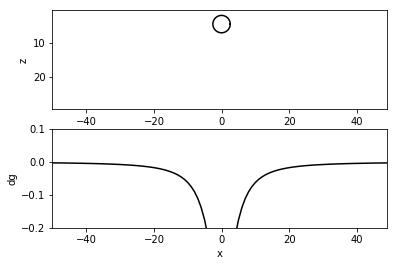

It  2 :


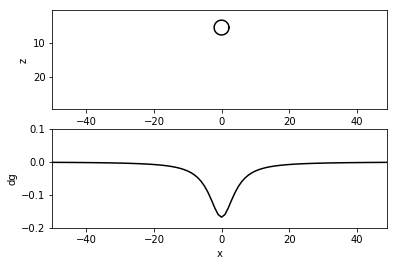

It  3 :


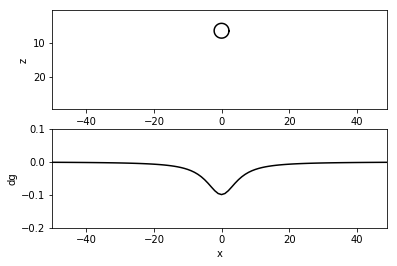

It  4 :


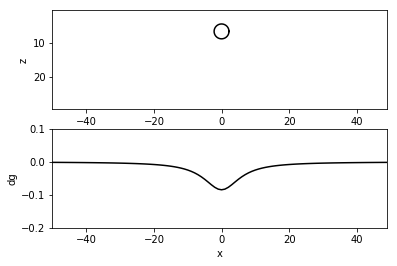

It  5 :


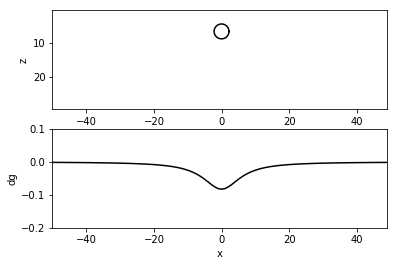

Fi:  2.199984487230192 m   6.611682018432883 m


In [228]:
G, rf, zf = solver(4,4,True)

Q7: Run your iterative inversion function for several different starting values $(r_0,z_0) = (6,8); (8,18); (2,17); (4,15); (2,5); \text{ and } (1,16)$, for example. Count the number of iterations to convergence for each set of starting values and note that convergence is not guaranteed for each set (if it is, try other starting values until you find examples of both convergence and non-convergence). Why do some converging inversions require more iterations? Why do others not converge?

In [229]:
# ANSWER 
#-------------------------------------------------------------------------
# Some converging inversions require more iterations perhaps because the
# initial guess is (although not implausible) is perhaps farther from the
# actual depth and radius than a guess like (2, 6) that only needs 1 iter
# -ration. Some don't converge (like the initial guesses of 2,17 and 1,16)
# perhaps (mathematically) because there are multiple solutions and the
# algorithm does not know which one it is. Or perhaps this is the nature of
# the problem where we perform partial derivative calculations (like Taylor
# expansion). We cannot choose a guess that is too far from the real answer.
#-------------------------------------------------------------------------
G, rf, zf = solver(6,8,False)
print('------- Convergent -------')
print()
G, rf, zf = solver(8,18,False)
print('------- Convergent -------')
print()
G, rf, zf = solver(2,17,False)
print('------- DIVERGENT -------')
print()
G, rf, zf = solver(4,15,False)
print('------- Convergent -------')
print()
G, rf, zf = solver(2,5,False)
print('------- Convergent -------')
print()
G, rf, zf = solver(1,16,False)
print('------- DIVERGENT -------')
print()

In:  6 m   8 m
It: 3
Fi:  2.207175189655148 m   6.6678584901451945 m
------- Convergent -------

In:  8 m   18 m
It: 5
Fi:  2.1999708222213483 m   6.611488121444502 m
------- Convergent -------

In:  2 m   17 m
Fi:  -28058.690328966608 m   5621045557.391315 m
------- DIVERGENT -------

In:  4 m   15 m
It: 4
Fi:  2.1999783766765733 m   6.611598604912757 m
------- Convergent -------

In:  2 m   5 m
It: 3
Fi:  2.1999852089649328 m   6.611691204625983 m
------- Convergent -------

In:  1 m   16 m
Fi:  -1418453.4361371258 m   13814922942100.857 m
------- DIVERGENT -------



Q8: What are the depth and radius of the tunnel? What are the uncertainties of these values? Is there a trade-off between the two parameters? For example, making the tunnel deeper and wider can also predict the data fairly well but making it deeper and smaller does not?

In [236]:
G, rf, zf = solver(4,4,False)

In:  4 m   4 m
It: 5
Fi:  2.199984487230192 m   6.611682018432883 m


In [237]:
# ANSWER 
#-------------------------------------------------------------------------
# The depth of the tunnel is: 6.611682018432883 +/- 1.0751487273667215 m
# The radius of the tunnel is: 2.199984487230192 +/- 0.12642681437529793 m
#
# There is a trade-off between the two parameters. For this, we look at the
# covariance matrix. The value is higher for depth than for radius. Higher 
# covariance means a higher trade-off. We can deduce this from the error
# ellipse too. Making the tunnel deeper and wider does predict the data 
# fairly well but making it deeper and smaller does not.
#-------------------------------------------------------------------------

# Similar to Exercise 1. Extension
o_d = stdev(dg)
cov_m = (o_d**2) * np.linalg.inv(G.transpose() @ G)
std_r = sqrt(cov_m[0,0]) ; std_z = sqrt(cov_m[1,1])
print("STD mdata: ", o_d)
print("Best radius:", rf, "+/-", std_r, "m")
print("Best depth:", zf, "+/-", std_z, "m")

STD mdata:  0.021612350673766163
Best radius: 2.199984487230192 +/- 0.12642681437529793 m
Best depth: 6.611682018432883 +/- 1.0751487273667215 m


Ellipse(xy=(2.199984487230192, 6.611682018432883), width=0.17758307990725375, height=2.1578179606111636, angle=175.1986967195002)


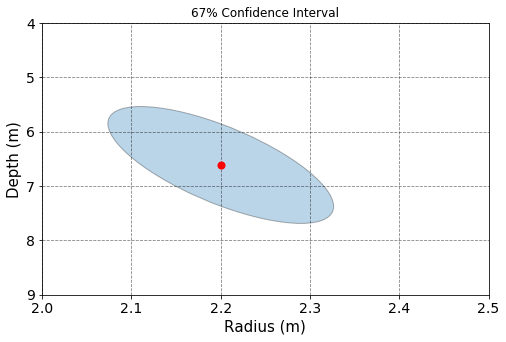

In [238]:
# Using the model covariance matrix, covlatlon, draw an error ellipse around the epicenter
# This following code is copied directly from Exercise 1. Extension
from matplotlib.patches import Ellipse
w,v = linalg.eig(cov_m)
major = 2*sqrt(w[0])
minor = 2*sqrt(w[1])
rota = degrees(arctan2(v[1,0],v[0,0]))
e = Ellipse((rf,zf),major,minor,rota, label = "Error ellipse")
e.set_alpha(0.1)
print(e)

import matplotlib as mpl; from matplotlib import pyplot as plt
%matplotlib inline

e_patch = mpl.patches.Ellipse(xy=[ 2.199984487230192, 6.611682018432883], width=0.17758307990725375, height=2.1578179606111636, angle = 175.1986967195002,edgecolor='black', lw=1, facecolor='tab:blue',alpha=0.3)

fig, ax = plt.subplots(figsize=(8, 5))
plt.grid(linestyle="--", color='black',zorder=0,alpha=0.5)
ax.add_patch(e_patch)
ax.set_xlim(2, 2.5)
ax.set_ylim(9, 4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Radius (m)',fontsize=15)
ax.set_ylabel('Depth (m)',fontsize=15)
ax.scatter(rf, zf,s = 50,color='red',zorder=20,marker='o') # Final guess
ax.set_title('67% Confidence Interval')
plt.show()

Q9: The following function `gnl` plots contours of the objective function $E(\mathbf {m}) =(\mathbf{\delta g} - \mathbf{\delta g}^p)^T \cdot (\mathbf{\delta g} - \mathbf{\delta g}^p)$, where $\mathbf{\delta g}^p$ contains the  values for the gravity anomalies predicted by equation (1) above. Is this objective function a quadratic function? Why (not)?

In [239]:
# ANSWER 
#-------------------------------------------------------------------------
# gn1 plots the contours of the objective function E(m). This objective
# function is a quadratic function as we are doing dg - dgp (which is a
# linear function). Here, we do (dg-dgp).transpose @ (dg-dgp) which is
# essentially two linear functions multiplied by each other. So a 
# simplistic way to think about this is set a = dg-dgp and 
# a = (dg-dgp).transpose. E is then a times a or a squared.
#-------------------------------------------------------------------------

def gnl(rmin,rmax,zmin,zmax,blank):
# rmin,max limits of plot for r (radius of tunnel)
# zmin,max limits of plot for z (depth to tunnel center)
# blank is false if 0, true for other values. If true, then r>0 and z>r.
    if rmin==0 and rmax==0 and zmin==0 and zmax==0:
        rmin = -2
        rmax = 10
        zmin = -0.75
        zmax = 19.75
    if blank:
        rmin = max(0,rmin)  
        zmin = max(rmin,zmin)  

    ngrid = 200
    r = arange(rmin,rmax,(rmax-rmin)/float(ngrid))
    z = arange(zmin,zmax,(zmax-zmin)/float(ngrid))

    E = zeros([len(z),len(r)])
    for i in arange(len(r)):
        for j in arange(len(z)):
            dgp = constant * r[i]**2 * z[j]/(x**2 + z[j]**2)
            E[j,i] = (dg - dgp).transpose() @ (dg - dgp)
            if blank & (z[j]<r[i]):
                E[j,i] = E[j,i] + NaN 

    v = logspace(-3,3,30) 
    X,Y = meshgrid(r,z)
    contour(X,Y,E,v) 
    xlabel('r (m)')
    ylabel('z (m)')
#     ylim(5.5,7.7)
#     xlim(2.05,2.35)
    show()

Q10: Run `gnl()` to plot contours of the objective function $E$, then graphically find the solution to the non-linear inverse problem, by directly reading it from the contour plot. Document your process and report the finding here.

In [240]:
# ANSWER 
#-------------------------------------------------------------------------
# The contours of the objective function E is below. Looking at the contour
# plots below, I see that the solution to the non-linear inverse problem
# should be in the bullseye feature. The middle of the bullseye feature
# is then rf and zf and the width and length can be used to determine
# the uncertainties in either direction. Reading from the contour plot,
# I get rf = ~2.20 m and zf = ~ 6.6 m, which is very close to the each.
# Reading directly from the second plot is more difficult.
#-------------------------------------------------------------------------

2.073557672854894 2.3264113016054897
5.536533291066162 7.686830745799604


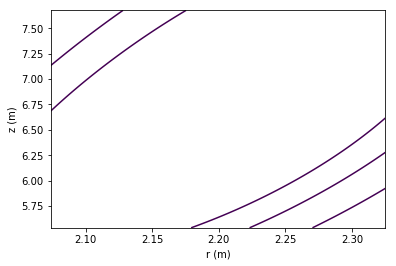

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


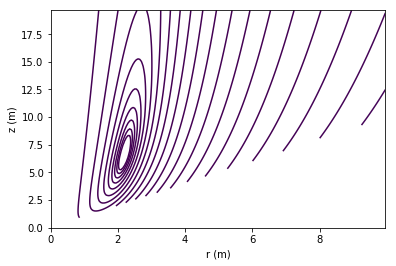

In [241]:
# Define the bounds of r and z using the best guess and its uncertainties and run gl()
rmin = rf - std_r; rmax = rf + std_r
print(rmin, rmax)
zmin = zf - std_z; zmax = zf + std_z
print(zmin,zmax)

gnl(rmin,rmax,zmin,zmax,True)

gnl(0,0,0,0,True)

Q11: Below write a function `gl(r0,z0)` that plots contours of the objective function $(\mathbf d - \mathbf{Gm})^T\cdot(\mathbf d - \mathbf{Gm})$ of the inverse problem that is linearized around the starting value $(r_0,z_0)$. Vector $\mathbf d$ is the difference between the observed anomalous gravity data and the anomalies predicted by the starting model, and $\mathbf m$ is the difference between a model vector in the considered part of model space and the starting model. Choose one of the starting models from Q7 and run `gl` after each iteration to visualize the updated objective function. 

It  1


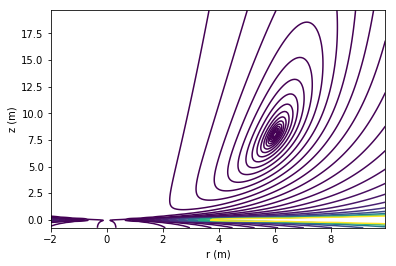

It  2


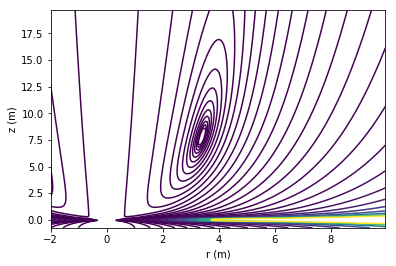

It  3


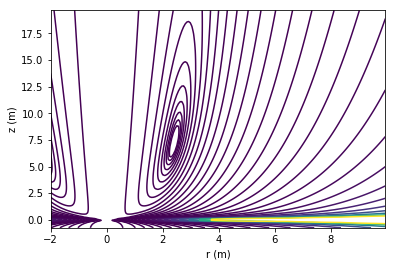

In [242]:
def gl(r_0,z_0,G,m_delta):
# r0 and z0 are the initial guesses for the radius and depth of the tunnel
# give the plot of the 2-dimensional model space a good range:
    r = arange(-2,10,0.06) 
    z = arange(-0.75,19.75,0.1) 
    
# calculate E(r,z)
    E = zeros([len(z),len(r)])
    Gm = G @ m_delta
    for i in arange(len(r)):
        for j in arange(len(z)):
            dgp = constant * r[i]**2 * z[j]/(x**2 + z[j]**2)
            d = dg - dgp
            dmGm = d-Gm
            E[j,i] = dmGm.transpose() @ dmGm
    
    X,Y = meshgrid(r,z)
    v = logspace(-3,3,30) 
    contour(X,Y,E,v) 
    xlabel('r (m)'); ylabel('z (m)')
    show()

def contourit(r0,z0):
    convcrit = 0.001
    for i in range(1,21):
        m_diff, d_diff, dgp, G = leastsquares(r0,z0)
        r_new = r0 + m_diff[0]; z_new = z0 + m_diff[1]
        iteration = i
        
        if m_diff[0] < convcrit and m_diff[1] < convcrit and (-0.001 < np.mean(d_diff) < 0.001): #convcrit defined
            break
        else:
            print("It ", iteration)
            gl(r0,z0,G,m_diff)
            r0 = r_new; z0 = z_new
                            
contourit(6,8) # pick the first one

Q12: For representative starting models, such as from Q7, use the visualization function `gl` to explain the con- and diverging behavior of the iterative linear inversion procedure for different starting models. Understanding this part is important for progressing into random-search non-linear inverse methods, such as MCMC.

In [243]:
# ANSWER 
#-------------------------------------------------------------------------
# Using the visualization function gl, I see that for the converging model
# example, there is one local minimum (or bullseye) that appears to be
# reflected across the y axis. This is a very clear bullseye.
# For the diverging model, we see two bullseye features that are close 
# to each other and are not very strong bullseyes. By Iteration 2, the contour
# lines are almost vertical to each other. By Iteration 3, we see that 
# new bullseye features are developing. By Iteration 5, no contour levels
# are found. My first guess is that perhaps there are two local minimum
# in the diverging model and the algorithm does not know which one to
# converge to or what to do. The contours for the diverging model at
# the beginning are quite large.
#-------------------------------------------------------------------------

It  1


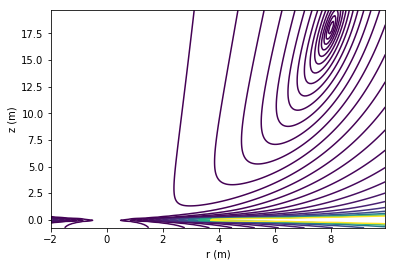

It  2


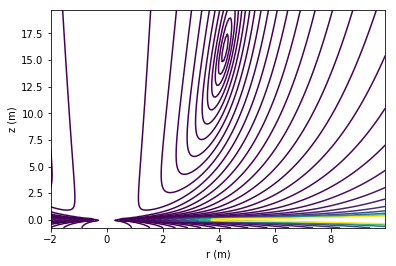

It  3


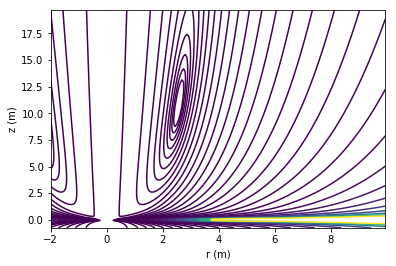

It  4


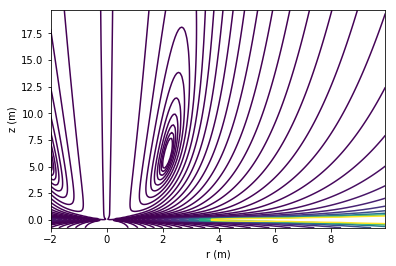

It  5


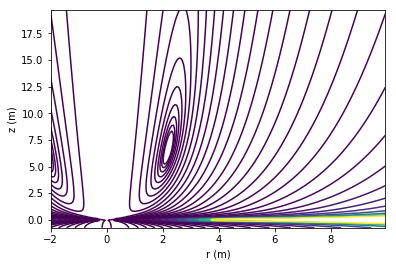

In [244]:
# Converging model example. Use starting values of 8,18
contourit(8,18)

It  1


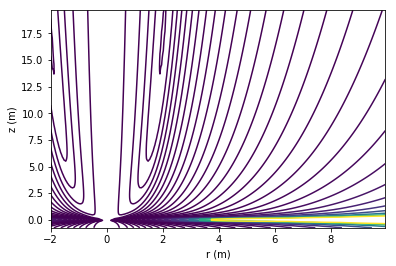

It  2


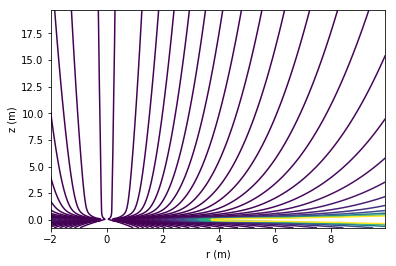

It  3


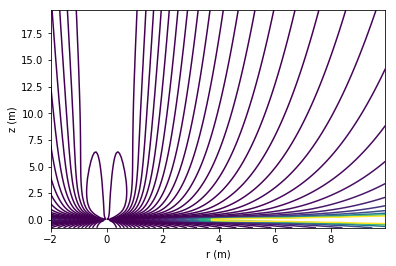

It  4


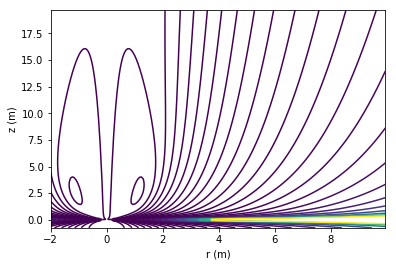

It  5


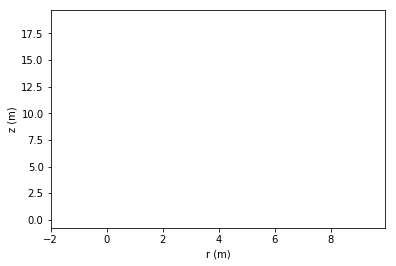

It  6


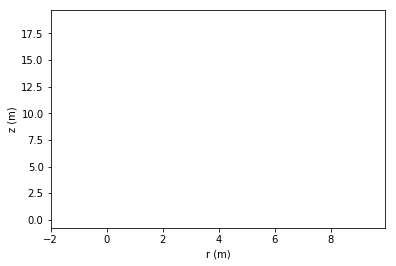

It  7


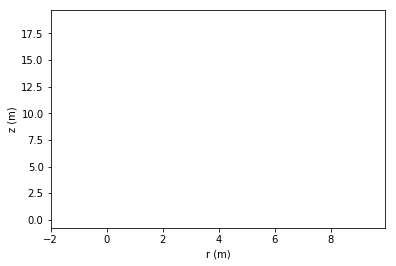

It  8


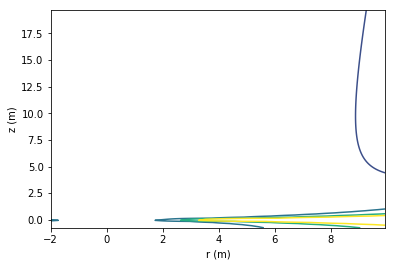

It  9


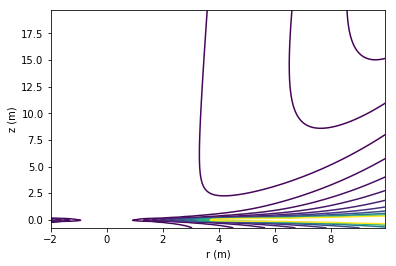

It  10


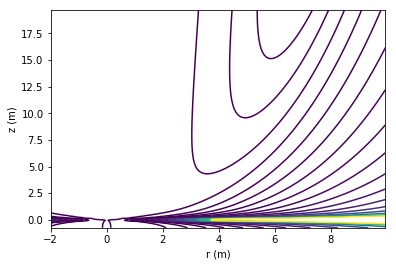

It  11


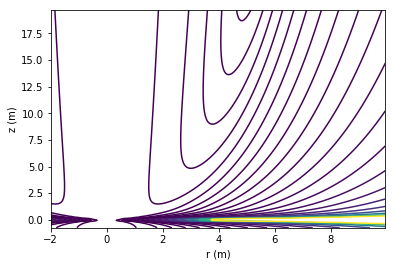

It  12


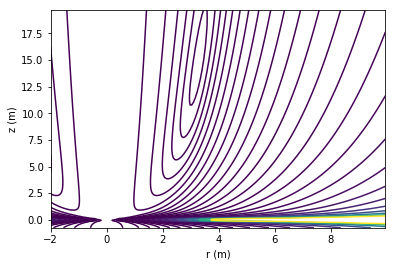

It  13


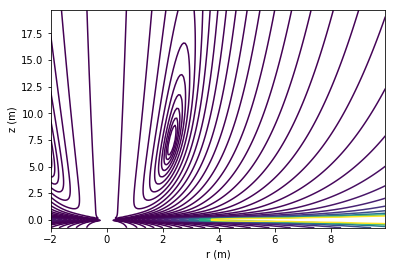

It  14


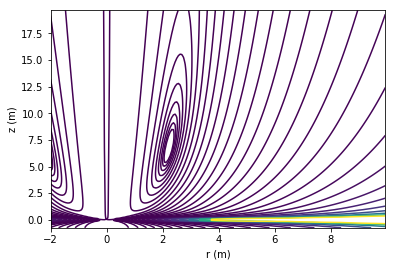

It  15


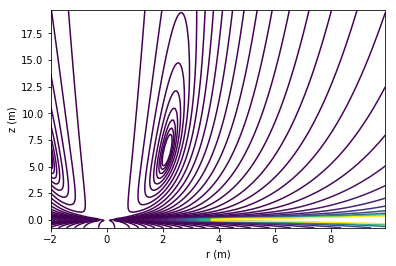

It  16


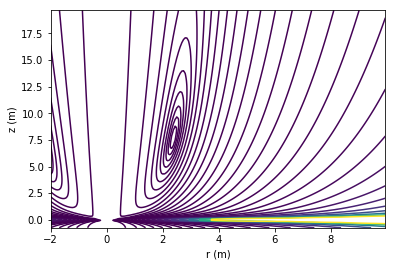

It  17


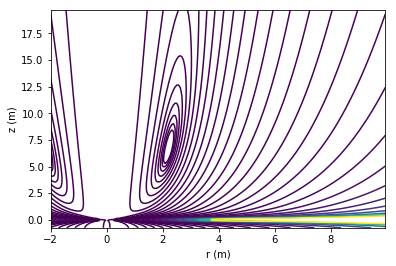

It  18


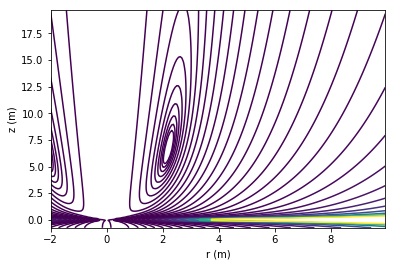

It  19


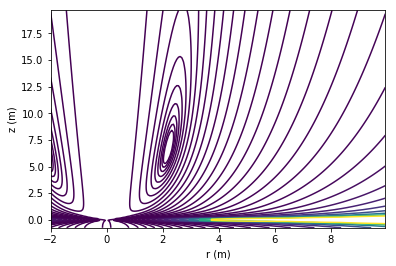

It  20


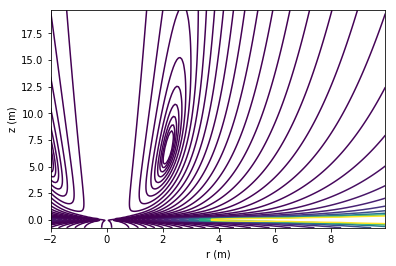

In [245]:
# Not converging model example. Use starting values of 2,17
contourit(2,17)